In [55]:
import os
import sys
import copy
import keras
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from model import get_model
import utils
from glob import glob
from tqdm import tqdm
from tensorflow.keras.models import load_model



In [2]:
def list_files(dir):
    r = []
    for root, dirs, files in os.walk(dir):
        for name in files:
            r.append(os.path.join(root, name))
    return r
files_list = list_files('train')
len(files_list)


49728

In [3]:
final_list = []
for i, img_path in enumerate(files_list):
    dict1 = {'index':i, 'path': img_path, 'label': img_path[-14:-10]}
    final_list.append(dict1)

df = pd.DataFrame(data = final_list, columns=['index', 'path', 'label'])               
df.head()

,index,path,label
0,0,train\0123\00000.png,0123
1,1,train\0123\00001.png,0123
2,2,train\0123\00002.png,0123
3,3,train\0123\00003.png,0123
4,4,train\0123\00004.png,0123


In [4]:
df_train, df_valid = train_test_split(df, test_size=0.2)

In [5]:
len(df_valid)

9946

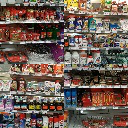

In [6]:
im = Image.open(df_valid.iloc[7900]['path'])
im

In [7]:
df_valid.iloc[7900]['label']

'3102'

In [8]:
def get_piece(a, size=128, cuts=2):

    """
       extracts each piece of the puzzle and returns
    """

    cut_len = size // cuts

    if cuts == 3:
        a = np.array([a[:, 0:cut_len, :], a[:, cut_len:cut_len * 2, :], a[:, cut_len * 2:cut_len * 3, :]])
        a = np.concatenate(
            (a[:, 0:cut_len, :, :], a[:, cut_len:cut_len * 2, :, :], a[:, cut_len * 2:cut_len * 3, :, :]))
    if cuts == 2:
        a = np.array([a[:, 0:cut_len, :], a[:, cut_len:, :]])
        a = np.concatenate((a[:, 0:cut_len, :, :], a[:, cut_len:, :, :]))

    return a

def load_data(df, cuts=2):

    """
        loads and returns data
    """

    # data = pd.read_csv(base_path + '{}.csv'.format(path))
    # path = base_path + path + '/'

    x = []
    y = []
    total = len(df)
    for i in tqdm(range(total)):

        im = Image.open(df.iloc[i]['path'])
        im = np.array(im).astype('float16')
        im = im / 255 - 0.5
        x.append(get_piece(im))

        label = df.iloc[i]['label']
        label = [int(i) for i in list(label)]
        y.append(label)

    return (np.array(x), np.expand_dims(np.array(y), axis=-1))

In [9]:
x_train, y_train = load_data(df_train)
x_val,   y_val   = load_data(df_valid)

100%|██████████| 9946/9946 [01:20<00:00, 123.27it/s]


In [10]:
# xt = x_train[:11700]
# yt = y_train[:11700]

# xv = x_val[:1800]
# yv = y_val[:1800]
# model.fit(xt, yt, batch_size=32, epochs=1, validation_data=(xv, yv))

In [11]:
model = get_model()
adam = keras.optimizers.Adam(learning_rate=.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam)


# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=10,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=val_dataset,
    validation_steps=10,
)

Epoch 1/10
622/622 [==============================] - 292s 463ms/step - loss: 0.5648 - val_loss: 0.3278
Epoch 2/10
622/622 [==============================] - 299s 480ms/step - loss: 0.3524 - val_loss: 0.2864
Epoch 3/10
622/622 [==============================] - 292s 469ms/step - loss: 0.2951 - val_loss: 0.2415
Epoch 4/10
622/622 [==============================] - 276s 444ms/step - loss: 0.2594 - val_loss: 0.2276
Epoch 5/10
622/622 [==============================] - 287s 461ms/step - loss: 0.2316 - val_loss: 0.2196
Epoch 6/10
622/622 [==============================] - 277s 446ms/step - loss: 0.2056 - val_loss: 0.1879
Epoch 7/10
622/622 [==============================] - 257s 413ms/step - loss: 0.1839 - val_loss: 0.1794
Epoch 8/10
622/622 [==============================] - 265s 426ms/step - loss: 0.1632 - val_loss: 0.1950
Epoch 9/10
622/622 [==============================] - 273s 438ms/step - loss: 0.1455 - val_loss: 0.1980
Epoch 10/10
622/622 [==============================] - 265s 427m

In [13]:
for img_name in glob('example_images/*'):
        # Open an example image using the PIL library
        example_image = np.asarray(Image.open(img_name))

        # Use instance of the Predictor class to predict the correct order of the current example image
        inp = np.expand_dims(get_piece(example_image), axis=0)

        prediction = model.predict(inp)[0]
        prediction = np.argmax(prediction, axis=1)
        # Example images are all shuffled in the "3120" order
        print(prediction)
        # # Example images are all shuffled in the "3120" order
        

# plt.imshow(x_test[im].astype('float64')+.5)
# plt.show()

# inp = np.expand_dims(extract_piece(x_test[im]), axis=0)
# out = model.predict(inp)[0]
# out = np.argmax(out, axis=1)


1/1 [==============================] - 3s 3s/step
[3 0 1 2]
1/1 [==============================] - 0s 35ms/step
[3 0 1 2]
1/1 [==============================] - 0s 34ms/step
[3 0 1 2]


In [41]:
def get_output(path_to_img):
    output = []
    im = np.asarray(Image.open(path_to_img))
    inp = np.expand_dims(get_piece(im), axis=0)
    prediction = model.predict(inp)[0]
    for i in prediction:
        for j in output:
            i[j] = -1
        pred = np.argmax(i)
        output.append(pred)

    output = list(map(str, output))
    result = ''.join(output)
    return result

In [44]:
get_output('example_images/3.png')

1/1 [==============================] - 0s 35ms/step


'3012'

In [47]:
model.save_weights('keras_trained_model/model')

In [50]:
# # Create a new model instance
# test_model = get_model()

# # Restore the weights
# test_model.load_weights('keras_trained_model/model')

In [51]:
# test_model.predict(inp)[0]

1/1 [==============================] - 0s 292ms/step


array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [52]:
model.save("model.h5")

In [57]:

# load model
test_model2 = load_model('model.h5')
# summarize model.
test_model2.predict(inp)[0]

1/1 [==============================] - 0s 338ms/step


array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)